# Bitcoin price forcasting using Machine Learning.
Here we're going to be trying to predict price fluctuations in the price of Bitcoin using some machine learning.

## Step 1 - Download and prepare the data
Let's download the data from our newly minted API.


In [4]:
from datetime import datetime

import numpy as np
import pandas as pd
import requests
import json

start_point = "1553327896" #"1388534400" # 2014-01-01
endpoint = int(datetime.now().timestamp())
download_url = f"http://127.0.0.1:10000/get-btc-data?fromDate={start_point}&toDate={endpoint}"
raw_data = requests.get(url=download_url)

if raw_data.status_code != 200:
    raise AssertionError("Could not fetch data from API.")

price_df = pd.DataFrame(json.loads(raw_data.content))
price_df["timestamp"] = pd.to_datetime(price_df['timestamp'], format="%Y-%m-%dT%H:%M:%SZ")
print(price_df.shape)
print(price_df.head())

(1567403, 6)
            timestamp     open     high      low    close  volumebtc
0 2019-03-23 07:59:00  3990.00  3990.00  3989.70  3989.70   3.165399
1 2019-03-23 08:00:00  3989.20  3991.63  3989.20  3991.63   0.518384
2 2019-03-23 08:01:00  3990.75  3991.74  3990.75  3991.74  11.777770
3 2019-03-23 08:02:00  3989.89  3989.89  3987.16  3988.49   4.173341
4 2019-03-23 08:03:00  3987.75  3987.76  3985.57  3985.92   5.948108


## Basic EDA

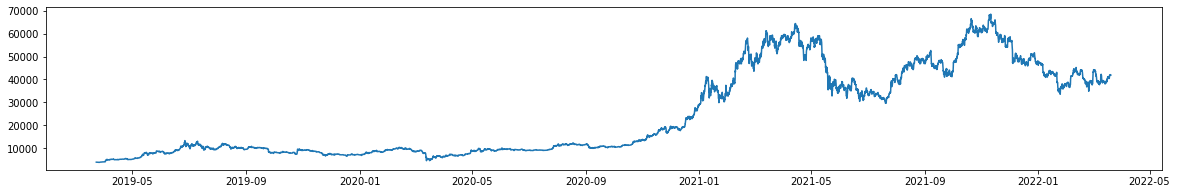

In [25]:
from typing import List, Tuple, Union
import matplotlib.pyplot as plt

def comparative_line_plot(x_y_datasets: List[Tuple[Union[pd.DataFrame, str]]], chart_title: str, num_points: Union[int, None] = 10000):
    """
    Create a line graph with n lines sampled down to 10k points.

    Incoming data should be a list [(df with two columns, X and Y, name: str), ...]
    """
    for df, name in x_y_datasets:
        if num_points:
            points = int(df.shape[0] / num_points)
            # Note that this will sample at mean, change it if that's not what you want.
            df["Y"] = df['Y'].rolling(points).mean()
            df = df.iloc[::points, :]
            plt.plot(df["X"], df["Y"], label=name)
    plt.title = chart_title
    plt.show()

price_df_sampled = price_df.copy()
price_df_sampled = price_df_sampled[["timestamp", "open"]]
price_df_sampled = price_df_sampled.rename(columns={"timestamp": "X", "open": "Y"})
price_df_sampled.head()
comparative_line_plot([(price_df_sampled, "Bitcoin Price USD")], "Bitcoin Price Over Time")

## Throw it at prophet to see what happens

This is a bit of a hail mary, but let's see what prophet does with it.

In [16]:
import prophet

df_for_prophet = price_df[["timestamp", 'open']]
df_for_prophet = df_for_prophet.rename(columns={"timestamp": "ds", "open": "y"})

# Lets take the last 6 months away.
df_for_prophet = df_for_prophet.loc[df_for_prophet["ds"] > datetime(2021, 7, 1)]

model = prophet.Prophet()
model.fit(df_for_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/jakesaunders/PycharmProjects/bitcoin-price-forcasting/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5819.79
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99   1.06898e+06      0.251416        941790           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199    1.1171e+06    0.00763801        286230      0.1324           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299   1.13017e+06    0.00573206        244159      0.4017      0.4017      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399   1.15282e+06      0.026211        168602           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499   1.16184e+06    0.00717532        106934           1           1      582   
  

0.6244      0.6244     1259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199   1.18152e+06    0.00429894       37560.5           1           1     1370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299   1.18242e+06    0.00444293       36793.6           1           1     1478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399   1.18299e+06     0.0130609       82743.8      0.4207      0.4207     1592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499   1.18364e+06     0.0124835       37117.2           1           1     1710   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599   1.18393e+06    0.00190361       22572.7      0.4977           1     1824   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0

In [ ]:
guesswork = model.make_future_dataframe(periods=(60 * 24 * 183), freq="T")
model.predict(guesswork)

/Users/jakesaunders/PycharmProjects/bitcoin-price-forcasting/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jakesaunders/PycharmProjects/bitcoin-price-forcasting/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
